In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt



In [9]:

df = pd.read_csv('data/powerball_cleaned.csv')

# Now 'df' contains your data in a DataFrame


In [10]:
df.head()

,Draw Date,first,second,third,fourth,fifth,sixth
0,9/30/23,19,30,37,44,46,22
1,9/27/23,1,7,46,47,63,7
2,9/25/23,10,12,22,36,50,4
3,9/23/23,1,12,20,33,66,21
4,9/20/23,16,27,59,62,63,23


In [184]:
#reduce df to x and y columns
data1 = df[["Draw Date", "sixth"]]

#rename columns
data1 = data1.rename(columns={"Draw Date":"Date"})

#convert date to dt, refomat to yyyymmdd
data1['Date'] = pd.to_datetime(data1['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data1 = data1.reindex(index=data1.index[::-1])

#set date as index
data1.set_index('Date', inplace=True)

data1.head()

,sixth
Date,
2010-02-03,24
2010-02-06,4
2010-02-10,34
2010-02-13,1
2010-02-17,15


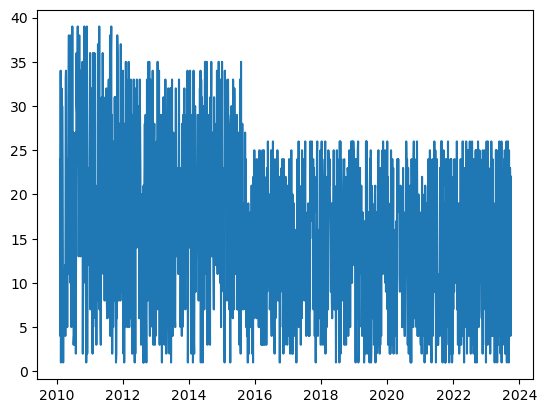

In [185]:
#plot historical amzn price
plt.plot(data1)

In [186]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [187]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'sixth(t-{i})'] = data['sixth'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data1, lookback)

shifted_df.head()

,sixth,sixth(t-1),sixth(t-2),sixth(t-3),sixth(t-4),sixth(t-5),sixth(t-6),sixth(t-7)
Date,,,,,,,,
2010-02-27,30,12.0,32.0,15.0,1.0,34.0,4.0,24.0
2010-03-03,23,30.0,12.0,32.0,15.0,1.0,34.0,4.0
2010-03-06,15,23.0,30.0,12.0,32.0,15.0,1.0,34.0
2010-03-10,1,15.0,23.0,30.0,12.0,32.0,15.0,1.0
2010-03-13,8,1.0,15.0,23.0,30.0,12.0,32.0,15.0


In [188]:
from sklearn.preprocessing import StandardScaler

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#Scale data
log_transformed_data = np.log(shifted_df_as_np)
# scaler = StandardScaler()

# scaled_data = scaler.fit_transform(shifted_df_as_np)


# split reference from deatures
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((1523, 7), (1523,), (1523,))

In [189]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1218, 7), (1218,), (152, 7), (152,), (153, 7), (153,))

In [190]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(256, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000)

Epoch 1/1000
39/39 [==============================] - 5s 31ms/step - loss: 2.3076 - mean_absolute_error: 1.2247 - val_loss: 0.7335 - val_mean_absolute_error: 0.6401
Epoch 2/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.7366 - mean_absolute_error: 0.6724 - val_loss: 0.7121 - val_mean_absolute_error: 0.6364
Epoch 3/1000
39/39 [==============================] - 0s 13ms/step - loss: 0.7255 - mean_absolute_error: 0.6689 - val_loss: 0.6985 - val_mean_absolute_error: 0.6758
Epoch 4/1000
39/39 [==============================] - 0s 12ms/step - loss: 0.7337 - mean_absolute_error: 0.6822 - val_loss: 0.7053 - val_mean_absolute_error: 0.6282
Epoch 5/1000
39/39 [==============================] - 0s 11ms/step - loss: 0.7377 - mean_absolute_error: 0.6749 - val_loss: 0.7282 - val_mean_absolute_error: 0.6279
Epoch 6/1000
39/39 [==============================] - 0s 12ms/step - loss: 0.7245 - mean_absolute_error: 0.6686 - val_loss: 0.6779 - val_mean_absolute_error: 0.6622
Epoch 7/10

39/39 [==============================] - 0s 9ms/step - loss: 0.7159 - mean_absolute_error: 0.6715 - val_loss: 0.7027 - val_mean_absolute_error: 0.6138
Epoch 51/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.7160 - mean_absolute_error: 0.6672 - val_loss: 0.7838 - val_mean_absolute_error: 0.6267
Epoch 52/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7166 - mean_absolute_error: 0.6613 - val_loss: 0.6582 - val_mean_absolute_error: 0.6528
Epoch 53/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7631 - mean_absolute_error: 0.6986 - val_loss: 0.6549 - val_mean_absolute_error: 0.6274
Epoch 54/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7499 - mean_absolute_error: 0.6893 - val_loss: 0.6722 - val_mean_absolute_error: 0.6166
Epoch 55/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7151 - mean_absolute_error: 0.6705 - val_loss: 0.6720 - val_mean_absolute_error: 0.6163
Epoch 56/1000
39/39 [===

Epoch 100/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7203 - mean_absolute_error: 0.6689 - val_loss: 0.6996 - val_mean_absolute_error: 0.6145
Epoch 101/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7121 - mean_absolute_error: 0.6650 - val_loss: 0.6960 - val_mean_absolute_error: 0.6137
Epoch 102/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7158 - mean_absolute_error: 0.6697 - val_loss: 0.6919 - val_mean_absolute_error: 0.6138
Epoch 103/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7186 - mean_absolute_error: 0.6637 - val_loss: 0.6634 - val_mean_absolute_error: 0.6605
Epoch 104/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7353 - mean_absolute_error: 0.6839 - val_loss: 0.7002 - val_mean_absolute_error: 0.6121
Epoch 105/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7107 - mean_absolute_error: 0.6634 - val_loss: 0.6666 - val_mean_absolute_error: 0.6170
Epoc

39/39 [==============================] - 0s 7ms/step - loss: 0.7067 - mean_absolute_error: 0.6613 - val_loss: 0.6628 - val_mean_absolute_error: 0.6444
Epoch 150/1000
39/39 [==============================] - 0s 6ms/step - loss: 0.6991 - mean_absolute_error: 0.6570 - val_loss: 0.6753 - val_mean_absolute_error: 0.6223
Epoch 151/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7025 - mean_absolute_error: 0.6587 - val_loss: 0.6639 - val_mean_absolute_error: 0.6510
Epoch 152/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7409 - mean_absolute_error: 0.6877 - val_loss: 0.6738 - val_mean_absolute_error: 0.6184
Epoch 153/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7040 - mean_absolute_error: 0.6631 - val_loss: 0.6632 - val_mean_absolute_error: 0.6540
Epoch 154/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7047 - mean_absolute_error: 0.6689 - val_loss: 0.7546 - val_mean_absolute_error: 0.6211
Epoch 155/1000
39/3

39/39 [==============================] - 0s 12ms/step - loss: 0.6951 - mean_absolute_error: 0.6531 - val_loss: 0.6747 - val_mean_absolute_error: 0.6419
Epoch 199/1000
39/39 [==============================] - 0s 9ms/step - loss: 0.7027 - mean_absolute_error: 0.6648 - val_loss: 0.6970 - val_mean_absolute_error: 0.6253
Epoch 200/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.6974 - mean_absolute_error: 0.6533 - val_loss: 0.6686 - val_mean_absolute_error: 0.6483
Epoch 201/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.7144 - mean_absolute_error: 0.6615 - val_loss: 0.7339 - val_mean_absolute_error: 0.6247
Epoch 202/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.6878 - mean_absolute_error: 0.6518 - val_loss: 0.7302 - val_mean_absolute_error: 0.6245
Epoch 203/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.6915 - mean_absolute_error: 0.6529 - val_loss: 0.6716 - val_mean_absolute_error: 0.6484
Epoch 204/1000
39/

39/39 [==============================] - 0s 7ms/step - loss: 0.6704 - mean_absolute_error: 0.6372 - val_loss: 0.7028 - val_mean_absolute_error: 0.6508
Epoch 248/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.6728 - mean_absolute_error: 0.6468 - val_loss: 0.7209 - val_mean_absolute_error: 0.6487
Epoch 249/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.6759 - mean_absolute_error: 0.6389 - val_loss: 0.7230 - val_mean_absolute_error: 0.6497
Epoch 250/1000
39/39 [==============================] - 0s 9ms/step - loss: 0.6763 - mean_absolute_error: 0.6384 - val_loss: 0.7014 - val_mean_absolute_error: 0.6526
Epoch 251/1000
39/39 [==============================] - 0s 9ms/step - loss: 0.6858 - mean_absolute_error: 0.6493 - val_loss: 0.7051 - val_mean_absolute_error: 0.6589
Epoch 252/1000
39/39 [==============================] - 0s 9ms/step - loss: 0.6748 - mean_absolute_error: 0.6398 - val_loss: 0.6933 - val_mean_absolute_error: 0.6632
Epoch 253/1000
39/3

39/39 [==============================] - 0s 8ms/step - loss: 0.6484 - mean_absolute_error: 0.6199 - val_loss: 0.7258 - val_mean_absolute_error: 0.6588
Epoch 297/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.6473 - mean_absolute_error: 0.6325 - val_loss: 0.7601 - val_mean_absolute_error: 0.6593
Epoch 298/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.6459 - mean_absolute_error: 0.6200 - val_loss: 0.7457 - val_mean_absolute_error: 0.6656
Epoch 299/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.6316 - mean_absolute_error: 0.6139 - val_loss: 0.7481 - val_mean_absolute_error: 0.6665
Epoch 300/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.6347 - mean_absolute_error: 0.6201 - val_loss: 0.7422 - val_mean_absolute_error: 0.6892
Epoch 301/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.6252 - mean_absolute_error: 0.6156 - val_loss: 0.7215 - val_mean_absolute_error: 0.6631
Epoch 302/1000
39/3

39/39 [==============================] - 0s 7ms/step - loss: 0.5053 - mean_absolute_error: 0.5369 - val_loss: 1.0380 - val_mean_absolute_error: 0.7770
Epoch 346/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.5099 - mean_absolute_error: 0.5361 - val_loss: 0.9842 - val_mean_absolute_error: 0.7645
Epoch 347/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.5159 - mean_absolute_error: 0.5402 - val_loss: 0.9511 - val_mean_absolute_error: 0.7356
Epoch 348/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.5000 - mean_absolute_error: 0.5336 - val_loss: 1.0474 - val_mean_absolute_error: 0.7770
Epoch 349/1000
39/39 [==============================] - 1s 14ms/step - loss: 0.5152 - mean_absolute_error: 0.5386 - val_loss: 0.9786 - val_mean_absolute_error: 0.7445
Epoch 350/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.4936 - mean_absolute_error: 0.5268 - val_loss: 1.0208 - val_mean_absolute_error: 0.7769
Epoch 351/1000
39

39/39 [==============================] - 0s 7ms/step - loss: 0.3696 - mean_absolute_error: 0.4406 - val_loss: 1.2177 - val_mean_absolute_error: 0.8531
Epoch 395/1000
39/39 [==============================] - 0s 6ms/step - loss: 0.3776 - mean_absolute_error: 0.4444 - val_loss: 1.1949 - val_mean_absolute_error: 0.8560
Epoch 396/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.4291 - mean_absolute_error: 0.4888 - val_loss: 1.2333 - val_mean_absolute_error: 0.8541
Epoch 397/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.3760 - mean_absolute_error: 0.4520 - val_loss: 1.1642 - val_mean_absolute_error: 0.8343
Epoch 398/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.4275 - mean_absolute_error: 0.4808 - val_loss: 1.1626 - val_mean_absolute_error: 0.8232
Epoch 399/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.4364 - mean_absolute_error: 0.4875 - val_loss: 1.1484 - val_mean_absolute_error: 0.8360
Epoch 400/1000
39/3

39/39 [==============================] - 0s 9ms/step - loss: 0.3241 - mean_absolute_error: 0.4177 - val_loss: 1.3308 - val_mean_absolute_error: 0.8810
Epoch 444/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.2654 - mean_absolute_error: 0.3675 - val_loss: 1.2936 - val_mean_absolute_error: 0.8547
Epoch 445/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.2547 - mean_absolute_error: 0.3541 - val_loss: 1.2880 - val_mean_absolute_error: 0.8413
Epoch 446/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.2268 - mean_absolute_error: 0.3191 - val_loss: 1.2479 - val_mean_absolute_error: 0.8266
Epoch 447/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.2274 - mean_absolute_error: 0.3248 - val_loss: 1.3415 - val_mean_absolute_error: 0.8799
Epoch 448/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.2274 - mean_absolute_error: 0.3307 - val_loss: 1.2875 - val_mean_absolute_error: 0.8423
Epoch 449/1000
3

39/39 [==============================] - 0s 7ms/step - loss: 0.1883 - mean_absolute_error: 0.3014 - val_loss: 1.2398 - val_mean_absolute_error: 0.8006
Epoch 493/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.1396 - mean_absolute_error: 0.2572 - val_loss: 1.1968 - val_mean_absolute_error: 0.8087
Epoch 494/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.1175 - mean_absolute_error: 0.2344 - val_loss: 1.3456 - val_mean_absolute_error: 0.8684
Epoch 495/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.1692 - mean_absolute_error: 0.2799 - val_loss: 1.1849 - val_mean_absolute_error: 0.7971
Epoch 496/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.1142 - mean_absolute_error: 0.2263 - val_loss: 1.2413 - val_mean_absolute_error: 0.8296
Epoch 497/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.1183 - mean_absolute_error: 0.2438 - val_loss: 1.2971 - val_mean_absolute_error: 0.8466
Epoch 498/1000
39/3

39/39 [==============================] - 0s 8ms/step - loss: 0.0808 - mean_absolute_error: 0.1971 - val_loss: 1.2877 - val_mean_absolute_error: 0.8596
Epoch 542/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0715 - mean_absolute_error: 0.1786 - val_loss: 1.2431 - val_mean_absolute_error: 0.8372
Epoch 543/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0665 - mean_absolute_error: 0.1662 - val_loss: 1.1922 - val_mean_absolute_error: 0.8124
Epoch 544/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.0498 - mean_absolute_error: 0.1452 - val_loss: 1.2202 - val_mean_absolute_error: 0.8388
Epoch 545/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.0432 - mean_absolute_error: 0.1300 - val_loss: 1.1978 - val_mean_absolute_error: 0.8242
Epoch 546/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.0446 - mean_absolute_error: 0.1357 - val_loss: 1.2288 - val_mean_absolute_error: 0.8365
Epoch 547/1000
3

39/39 [==============================] - 0s 7ms/step - loss: 0.0243 - mean_absolute_error: 0.1072 - val_loss: 1.1727 - val_mean_absolute_error: 0.8039
Epoch 591/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0241 - mean_absolute_error: 0.1051 - val_loss: 1.1771 - val_mean_absolute_error: 0.8100
Epoch 592/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0331 - mean_absolute_error: 0.1190 - val_loss: 1.1263 - val_mean_absolute_error: 0.7966
Epoch 593/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0349 - mean_absolute_error: 0.1209 - val_loss: 1.1417 - val_mean_absolute_error: 0.7905
Epoch 594/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0292 - mean_absolute_error: 0.1153 - val_loss: 1.1458 - val_mean_absolute_error: 0.7900
Epoch 595/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0228 - mean_absolute_error: 0.0995 - val_loss: 1.1724 - val_mean_absolute_error: 0.7986
Epoch 596/1000
39/3

39/39 [==============================] - 0s 7ms/step - loss: 0.0300 - mean_absolute_error: 0.1201 - val_loss: 1.1662 - val_mean_absolute_error: 0.8220
Epoch 640/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0253 - mean_absolute_error: 0.1058 - val_loss: 1.1534 - val_mean_absolute_error: 0.8092
Epoch 641/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0163 - mean_absolute_error: 0.0874 - val_loss: 1.1888 - val_mean_absolute_error: 0.8142
Epoch 642/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0142 - mean_absolute_error: 0.0791 - val_loss: 1.1728 - val_mean_absolute_error: 0.8150
Epoch 643/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0123 - mean_absolute_error: 0.0730 - val_loss: 1.1270 - val_mean_absolute_error: 0.7952
Epoch 644/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0107 - mean_absolute_error: 0.0661 - val_loss: 1.1421 - val_mean_absolute_error: 0.8093
Epoch 645/1000
39/3

39/39 [==============================] - 0s 8ms/step - loss: 0.0113 - mean_absolute_error: 0.0673 - val_loss: 1.1245 - val_mean_absolute_error: 0.8125
Epoch 689/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0108 - mean_absolute_error: 0.0709 - val_loss: 1.1459 - val_mean_absolute_error: 0.8240
Epoch 690/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0108 - mean_absolute_error: 0.0666 - val_loss: 1.1601 - val_mean_absolute_error: 0.8321
Epoch 691/1000
39/39 [==============================] - 0s 9ms/step - loss: 0.0117 - mean_absolute_error: 0.0701 - val_loss: 1.1609 - val_mean_absolute_error: 0.8316
Epoch 692/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.0119 - mean_absolute_error: 0.0718 - val_loss: 1.1055 - val_mean_absolute_error: 0.8087
Epoch 693/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.0135 - mean_absolute_error: 0.0771 - val_loss: 1.1829 - val_mean_absolute_error: 0.8391
Epoch 694/1000
39

39/39 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.0513 - val_loss: 1.1149 - val_mean_absolute_error: 0.8103
Epoch 738/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_absolute_error: 0.0480 - val_loss: 1.1370 - val_mean_absolute_error: 0.8130
Epoch 739/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0090 - mean_absolute_error: 0.0620 - val_loss: 1.1328 - val_mean_absolute_error: 0.8189
Epoch 740/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0093 - mean_absolute_error: 0.0650 - val_loss: 1.1032 - val_mean_absolute_error: 0.8007
Epoch 741/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0154 - mean_absolute_error: 0.0798 - val_loss: 1.1208 - val_mean_absolute_error: 0.8143
Epoch 742/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0091 - mean_absolute_error: 0.0663 - val_loss: 1.1092 - val_mean_absolute_error: 0.8043
Epoch 743/1000
39/3

39/39 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_absolute_error: 0.0313 - val_loss: 1.1103 - val_mean_absolute_error: 0.8051
Epoch 787/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0345 - val_loss: 1.0940 - val_mean_absolute_error: 0.8000
Epoch 788/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_absolute_error: 0.0384 - val_loss: 1.1149 - val_mean_absolute_error: 0.8111
Epoch 789/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0440 - val_loss: 1.1196 - val_mean_absolute_error: 0.8104
Epoch 790/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0429 - val_loss: 1.1145 - val_mean_absolute_error: 0.8082
Epoch 791/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_absolute_error: 0.0406 - val_loss: 1.1164 - val_mean_absolute_error: 0.8116
Epoch 792/1000
39/

39/39 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0377 - val_loss: 1.1253 - val_mean_absolute_error: 0.8163
Epoch 836/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_absolute_error: 0.0310 - val_loss: 1.1133 - val_mean_absolute_error: 0.8110
Epoch 837/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_absolute_error: 0.0241 - val_loss: 1.1143 - val_mean_absolute_error: 0.8136
Epoch 838/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0247 - val_loss: 1.1249 - val_mean_absolute_error: 0.8154
Epoch 839/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0271 - val_loss: 1.1176 - val_mean_absolute_error: 0.8162
Epoch 840/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_absolute_error: 0.0566 - val_loss: 1.1062 - val_mean_absolute_error: 0.8087
Epoch 841/1000
39/3

39/39 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_absolute_error: 0.0360 - val_loss: 1.1001 - val_mean_absolute_error: 0.8001
Epoch 885/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0414 - val_loss: 1.1097 - val_mean_absolute_error: 0.8014
Epoch 886/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_error: 0.0509 - val_loss: 1.1221 - val_mean_absolute_error: 0.8067
Epoch 887/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_absolute_error: 0.0573 - val_loss: 1.0913 - val_mean_absolute_error: 0.7982
Epoch 888/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0524 - val_loss: 1.1041 - val_mean_absolute_error: 0.8080
Epoch 889/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0556 - val_loss: 1.1255 - val_mean_absolute_error: 0.8089
Epoch 890/1000
39/3

39/39 [==============================] - 0s 7ms/step - loss: 9.0757e-04 - mean_absolute_error: 0.0202 - val_loss: 1.1101 - val_mean_absolute_error: 0.8068
Epoch 934/1000
39/39 [==============================] - 0s 7ms/step - loss: 7.5906e-04 - mean_absolute_error: 0.0179 - val_loss: 1.1038 - val_mean_absolute_error: 0.8064
Epoch 935/1000
39/39 [==============================] - 0s 7ms/step - loss: 7.2849e-04 - mean_absolute_error: 0.0179 - val_loss: 1.1055 - val_mean_absolute_error: 0.8072
Epoch 936/1000
39/39 [==============================] - 0s 7ms/step - loss: 6.4028e-04 - mean_absolute_error: 0.0168 - val_loss: 1.0989 - val_mean_absolute_error: 0.8044
Epoch 937/1000
39/39 [==============================] - 0s 7ms/step - loss: 7.6645e-04 - mean_absolute_error: 0.0182 - val_loss: 1.0962 - val_mean_absolute_error: 0.8049
Epoch 938/1000
39/39 [==============================] - 0s 7ms/step - loss: 7.6845e-04 - mean_absolute_error: 0.0185 - val_loss: 1.1030 - val_mean_absolute_error: 0.

Epoch 982/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_absolute_error: 0.0233 - val_loss: 1.0961 - val_mean_absolute_error: 0.8089
Epoch 983/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_absolute_error: 0.0243 - val_loss: 1.1048 - val_mean_absolute_error: 0.8163
Epoch 984/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0260 - val_loss: 1.1096 - val_mean_absolute_error: 0.8131
Epoch 985/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0300 - val_loss: 1.1090 - val_mean_absolute_error: 0.8156
Epoch 986/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0298 - val_loss: 1.1208 - val_mean_absolute_error: 0.8184
Epoch 987/1000
39/39 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_absolute_error: 0.0354 - val_loss: 1.1209 - val_mean_absolute_error: 0.8188
Epoc

39/39 [==============================] - 1s 3ms/step


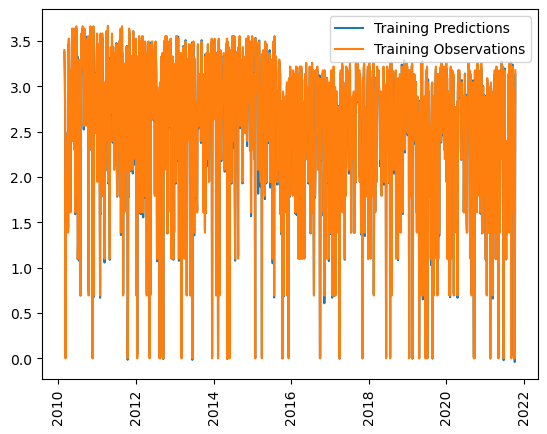

In [191]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, (train_predictions))
plt.plot(dates_train1, (y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [192]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 1.0928843021392822
Val MAE: 0.8078160285949707


5/5 [==============================] - 0s 4ms/step


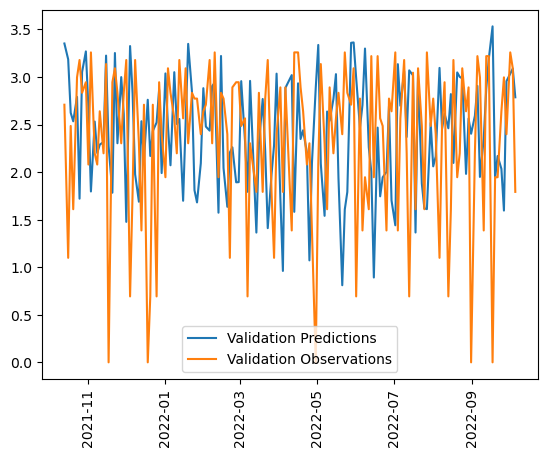

In [193]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, (val_predictions))
plt.plot(dates_val1, (y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [194]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 1.078674077987671
Test MAE: 0.8052726984024048


5/5 [==============================] - 0s 3ms/step


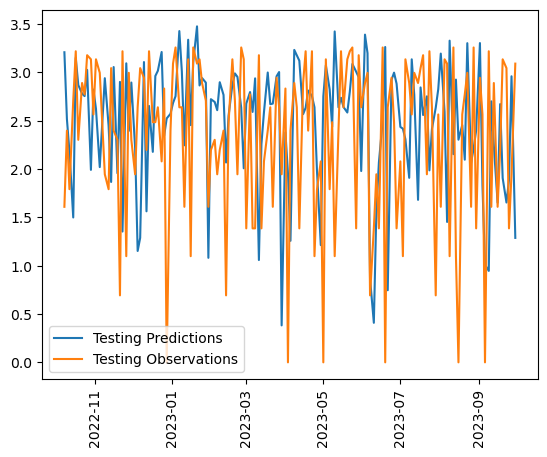

In [195]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1,(test_predictions))
plt.plot(dates_test1, (y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [196]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  -0.5384315850587114


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [197]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test1[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test1[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 22ms/step
[1.2877216, 1.3505603, 1.1105217, 2.8834138, 2.6464052, 2.737526, 0.80034685]
2023-10-01
2023-10-02
2023-10-03
2023-10-04
2023-10-05
2023-10-06
2023-10-07


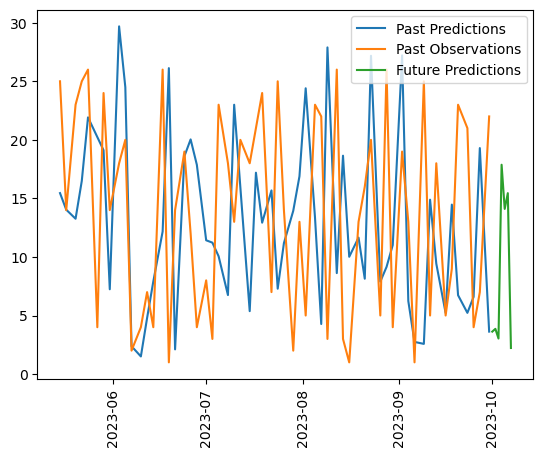

In [198]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test1[-60:], np.exp(test_predictions[-60:]))
plt.plot(dates_test1[-60:],np.exp(y_test1[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [199]:
# Export model1 to HDF5 file
model.save("pb.h5")

In [200]:
predict = np.exp(predictions)

print(predict)

[ 3.624519   3.8595874  3.0359416 17.87519   14.103249  15.448718
  2.226313 ]
